In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from typing import Dict
import matplotlib.pyplot as plt

In [5]:
!unzip 'Gender.zip'

Archive:  Gender.zip
  inflating: Gender/KorNet.py        
   creating: Gender/testing/
   creating: Gender/testing/face/
  inflating: Gender/testing/face/1.jpg  
  inflating: Gender/testing/face/2.jpg  
  inflating: Gender/testing/face/3.jpg  
  inflating: Gender/testing/face/4.jpg  
  inflating: Gender/testing/face/5.jpg  
  inflating: Gender/testing/face/6.jpg  
  inflating: Gender/testing/face/7.jpg  
  inflating: Gender/testing/face/8.jpg  
   creating: Gender/train/
   creating: Gender/train/1female/
  inflating: Gender/train/1female/0.jpg  
  inflating: Gender/train/1female/1.jpg  
  inflating: Gender/train/1female/10.jpg  
  inflating: Gender/train/1female/100.jpg  
  inflating: Gender/train/1female/101.jpg  
  inflating: Gender/train/1female/102.jpg  
  inflating: Gender/train/1female/103.jpg  
  inflating: Gender/train/1female/104.jpg  
  inflating: Gender/train/1female/105.jpg  
  inflating: Gender/train/1female/106.jpg  
  inflating: Gender/train/1female/107.jpg  
  inflati

In [6]:
BATCH_SIZE = 128
crop_size = 64

In [7]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(70),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor()
    ])
}

In [8]:
train_set = torchvision.datasets.ImageFolder(root='/content/Gender/train', transform=transform['train'])
test_set = torchvision.datasets.ImageFolder(root='/content/Gender/validation', transform=transform['test'])

In [9]:
assert train_set.classes == ['1female', '2male']

In [10]:
trainloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
class GenderNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),        
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(crop_size * 4 * 4, 128),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(128, 2),
            nn.LogSoftmax()
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.fc(x)
        return x

In [12]:
model = GenderNet()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [13]:
def training_loop(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [14]:
  train_cost, test_cost = [], []
  train_acc, test_acc = [], []
  for i in range (100):
      cost, acc = training_loop('train', train_set, trainloader, model, criterion, optimizer)
      train_cost.append(cost)
      train_acc.append(acc)
      with torch.no_grad():
          cost, acc = training_loop('test', test_set, testloader, model, criterion, optimizer)
          test_cost.append(cost)
          test_acc.append(acc)
      print(f'Epoch: {i+1}, Train Cost: {train_cost[-1]}, Test Cost: {test_cost[-1]}, Train Accuracy: {train_acc[-1]}, , Test Accuracy: {test_acc[-1]}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1, Train Cost: 0.6952820611000061, Test Cost: 0.6923717578252157, Train Accuracy: 0.4975, , Test Accuracy: 0.5041666666666667
Epoch: 2, Train Cost: 0.6924453783035278, Test Cost: 0.6921027143796284, Train Accuracy: 0.5325, , Test Accuracy: 0.5833333333333334
Epoch: 3, Train Cost: 0.6923231029510498, Test Cost: 0.6912395278612773, Train Accuracy: 0.5125, , Test Accuracy: 0.5
Epoch: 4, Train Cost: 0.693469340801239, Test Cost: 0.6903385480244955, Train Accuracy: 0.5, , Test Accuracy: 0.5666666666666667
Epoch: 5, Train Cost: 0.6927931737899781, Test Cost: 0.693982195854187, Train Accuracy: 0.5175, , Test Accuracy: 0.5
Epoch: 6, Train Cost: 0.6936706399917603, Test Cost: 0.6926482478777568, Train Accuracy: 0.5, , Test Accuracy: 0.5
Epoch: 7, Train Cost: 0.6926908779144287, Test Cost: 0.6900256236394247, Train Accuracy: 0.51875, , Test Accuracy: 0.6125
Epoch: 8, Train Cost: 0.689435269832611, Test Cost: 0.6859990755716959, Train Accuracy: 0.56375, , Test Accuracy: 0.5625
Epoch: 9, Tr

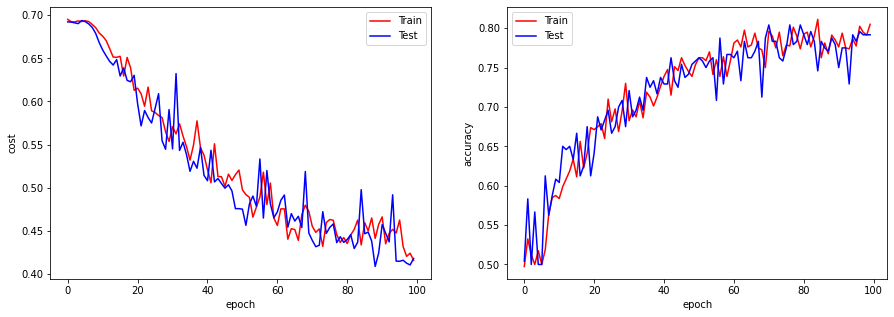

In [15]:
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.plot(train_cost, 'r-', label='Train')
    plt.plot(test_cost, 'b-', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()

    plt.subplot(122)
    plt.plot(train_acc, 'r-', label='Train')
    plt.plot(test_acc, 'b-', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()